## Model runs, data, and analysis routines for exploring the "Ligand-Iron-Microbe" feedback

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Oct  7 17:06:41 2019

@author: jml1
"""

from geopy.distance import geodesic as ge
import csv
import matplotlib.pyplot as plt
import cmocean           as cm
import matplotlib        as mp
import netCDF4           as nc
import numpy             as np
import numpy.ma          as nm
import pandas            as pd
from matplotlib.ticker     import FormatStrFormatter
from itertools             import zip_longest

**Nutboxmod provides "model" which is the fortran model compiled with "f2py"**

In [2]:
import importlib.util
spec = importlib.util.spec_from_file_location("nutboxmod", "nutboxmod.cpython-37m-darwin.so")
nutboxmod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(nutboxmod)

**Set runtime flags and options**

In [3]:
# Set to TRUE, the script will call the box model ninc^2 times, set to false and it will skip to the plotting
RUNMODEL=False

# Number of increments in parameter space
nincs=100

# Fixed value for uniform ligand control experiment
fixedligconc=1.0

# Do the analysis using nitrate (NP=16) or native phosphate (NP=1)
R_np=16

# Convert mol/kg to mol/m3
conv = 1024.5 

#This is a data-based estimate of gamma/lambda performed offline.
data_goverl=np.log10(np.array((1/0.84e-5,1/1.82e-3)))

# Print out objective function reference values
PRINTREF=True

# Filenames that store values used for model input and model output
finname ='boxmodel_input.csv'
foutname='boxmodel_output.csv'

**Define functions used later**

In [4]:
def oceanmasks(xc,yc,maskin):    
    from scipy.interpolate import griddata

    nzdim=0
    # Find if input dimensions are 3d or 2d
    if np.ndim(maskin)>2:
        nzdim=np.size(maskin,2)
        if np.ndim(xc)>2:
            xc=xc[:,:,0]
        if np.ndim(yc)>2:
            yc=yc[:,:,0]
            
    mask_file='woa13_basinmask_01.msk'

    x = np.loadtxt(mask_file,delimiter=',',usecols=(1,),skiprows=2)
    y = np.loadtxt(mask_file,delimiter=',',usecols=(0,),skiprows=2)
    basinfile = np.loadtxt(mask_file,delimiter=',',usecols=(2,),skiprows=2)
        
    # Find out if the grid has been rotated and rotate so range is the same as input grid
    if (np.min(x)<0) != (np.min(xc)<0):
        x[x<0]=x[x<0]+360

    basinmask = griddata((x, y), basinfile, (xc,yc), method = 'nearest')

    basinmask[basinmask==12]=2 # Add the Sea of Japan to the Pacific
    basinmask[basinmask==56]=3 # Add Bay of Bengal to Indian Ocean
    basinmask[basinmask==53]=0 # Zero out Caspian Sea

    so_mask     = np.copy(basinmask)
    so_mask[so_mask!=10]=0
    so_mask[so_mask==10]=1
    arctic_mask = np.copy(basinmask)
    arctic_mask[arctic_mask!=11]=0
    arctic_mask[arctic_mask==11]=1

    # Divide Southern Ocean into Atlantic, Indian and Pacific Sectors
    tmp=basinmask[:,0:len(np.unique(yc[yc<=-45]))] 
    basinmask[:,0:np.size(tmp,1)]=np.transpose(np.tile(tmp[:,-1],[np.size(tmp,1),1]))
    atlantic_mask = np.copy(basinmask)
    atlantic_mask[atlantic_mask!=1]=0
    atlantic_mask[atlantic_mask==1]=1
    indian_mask   = np.copy(basinmask)
    indian_mask[indian_mask!=3]=0
    indian_mask[indian_mask==3]=1
    pacific_mask  = np.copy(basinmask)
    pacific_mask[pacific_mask!=2]=0
    pacific_mask[pacific_mask==2]=1
    
    # if input was 3d, then extent mask to 3d
    if nzdim>0:
        atlantic_mask = np.tile(atlantic_mask[:,:,np.newaxis],(1,1,nzdim))*maskin
        pacific_mask  = np.tile(pacific_mask [:,:,np.newaxis],(1,1,nzdim))*maskin
        indian_mask   = np.tile(indian_mask  [:,:,np.newaxis],(1,1,nzdim))*maskin
        so_mask       = np.tile(so_mask      [:,:,np.newaxis],(1,1,nzdim))*maskin
        arctic_mask   = np.tile(arctic_mask  [:,:,np.newaxis],(1,1,nzdim))*maskin
        
    return atlantic_mask, pacific_mask, indian_mask, so_mask, arctic_mask

def calc_cost(modin,ref,stdev,iters=1): 
# Use the old way using masked arrays or ndarrays
    if np.ndim(modin)<=1:
        iters=1
    else:
        iters=np.max(np.shape(modin))

    cost=np.sum(np.power(modin.transpose()-np.tile(ref,(iters,1)),2)/np.tile(np.power(stdev,2),(iters,1)),axis=1)
    return cost

def calc_boxmodel_vars(data_pd,area,ivar,nref,nstd,fref,fstd,lref,lstd,Rcp=117,Rnp=16):   
    # Calculate box model diagnostics - requires pandas input
    global ncost, fcost, lcost, pstar, nsurfmean, fsurfmean, lsurfmean, \
           nso, fso, lso, nna, fna, lna, ndo, fdo, ldo, nlimit, export, expbox

    tlen=data_pd.shape[0]
    
    # Calculate cost function                                  
    nc=calc_cost(np.array((data_pd.p1[:tlen]*Rnp ,data_pd.p2[:tlen]*Rnp ,data_pd.p3[:tlen]*Rnp)) ,nref,nstd)
    fc=calc_cost(np.array((data_pd.f1[:tlen]     ,data_pd.f2[:tlen]     ,data_pd.f3[:tlen]))     ,fref,fstd)
    lc=calc_cost(np.array((data_pd.l1[:tlen]     ,data_pd.l2[:tlen]     ,data_pd.l3[:tlen]))     ,lref,lstd)
    
    # Store final cost function values
    ncost[ivar]=nc[-1]
    fcost[ivar]=fc[-1]
    lcost[ivar]=lc[-1]
    
    molpsm1_2_gtcym1=Rcp*86400*365*12*1e-15 # Convert mol P/s to GtC/yr
    pstar[ivar]=data_pd.pstar.tail(1)
    expbox[ivar,0] =data_pd.export1.tail(1).to_numpy(copy=True)*molpsm1_2_gtcym1
    expbox[ivar,1] =data_pd.export2.tail(1).to_numpy(copy=True)*molpsm1_2_gtcym1
    export[ivar]   =(data_pd.export1.tail(1).to_numpy(copy=True)+data_pd.export2.tail(1))*molpsm1_2_gtcym1 
    
    nlimit[ivar]=data_pd.lim.tail(1).to_numpy(copy=True)
#   Old nutrient limit text codes.
#    tmp=['XX','XX','XX','XX','XX','XX','XX','XX','XX','XX','XX',
#         'PP','PI','PL','PC','XX','XX','XX','XX','XX','XX',
#         'IP','II','IL','IC','XX','XX','XX','XX','XX','XX',
#         'LP','LI','LL','LC','XX','XX','XX','XX','XX','XX',
#         'CP','CI','CL','CC']
#    nlimit[ivar]=np.double(tmp.index(data_pd.lim.tail(1).values))
    
    nsm=np.array((data_pd.p1*area[0]+data_pd.p2*area[1])/(area[0]+area[1]))*Rnp
    fsm=np.array((data_pd.f1*area[0]+data_pd.f2*area[1])/(area[0]+area[1]))
    lsm=np.array((data_pd.l1*area[0]+data_pd.l2*area[1])/(area[0]+area[1]))  
    
    nsurfmean[ivar]=nsm[-1]
    fsurfmean[ivar]=fsm[-1]
    lsurfmean[ivar]=lsm[-1]
    
    nso[ivar]=data_pd.p1.tail(1).to_numpy(copy=True)*Rnp
    fso[ivar]=data_pd.f1.tail(1).to_numpy(copy=True)
    lso[ivar]=data_pd.l1.tail(1).to_numpy(copy=True)
    
    nna[ivar]=data_pd.p2.tail(1).to_numpy(copy=True)*Rnp
    fna[ivar]=data_pd.f2.tail(1).to_numpy(copy=True)
    lna[ivar]=data_pd.l2.tail(1).to_numpy(copy=True)
    
    ndo[ivar]=data_pd.p3.tail(1).to_numpy(copy=True)*Rnp
    fdo[ivar]=data_pd.f3.tail(1).to_numpy(copy=True)
    ldo[ivar]=data_pd.l3.tail(1).to_numpy(copy=True)
           
def run_boxmodel_iter(parray,farray,larray,gamma_fe,lt_rate,
                      dustdep,alpha_yr,psi,dlambdadz,niters,ninit,
                      nref,nstd,fref,fstd,lref,lstd,Rcp=117,Rnp=16):
    
    global ncost, fcost, lcost, pstar, nsurfmean, fsurfmean, lsurfmean, \
           nso, fso, lso, nna, fna, lna, ndo, fdo, ldo, nlimit, export, expbox
           
    for ivar in range(niters):
        if np.remainder(ivar,250)==0:
            print("Running iteration "+np.str(ivar+1)+" out of "+np.str(niters))
        
        # Need to run for slightly different periods of time for deep ocean equilibrium,
        if np.logical_and((lt_rate[ivar]/3e7)>=(10**1.25),(gamma_fe[ivar]/106)<=(10**-4)):
            # run the wider upper left corner for a hundred thousand years to equilibrium
            maxyears    = 1e5
            outputyears = 1e2
        else:
            # run the rest of the domain for ten thousand years to equilibrium
            maxyears    = 1e4
            outputyears = 10                              
            
        # Convert umol/kg or nmol/kg to mol/kg
        pin = parray[ivar]*1.0e-6
        fin = farray[ivar]*1.0e-9
        lin = larray[ivar]*1.0e-9
        gin = gamma_fe[ivar]
        lif = lt_rate[ivar]
        
        tout,pout,fout,lout,epout,nlout,psout = nutboxmod.model(maxyears,outputyears,
                    pin,fin,lin,gin,lif,dustdep,alpha_yr,dlambdadz,psi,ivar+ninit)
        
        # Direct model output is a fixed length of outstepmax (=10000 lines), so is maxyears/outputyears is
        #  less than 10000 need to cut off the zeros from the end of the output arrays
        tlen=np.int(maxyears/outputyears)
        
        data_pd = pd.DataFrame(np.hstack((tout[:tlen,np.newaxis],pout[:,:tlen].T,fout[:,:tlen].T,lout[:,:tlen].T,epout[0:2,:tlen].T,nlout[:tlen,np.newaxis],psout[:tlen,np.newaxis])),
                               columns=["t","p1","p2","p3","f1","f2","f3","l1","l2","l3","export1","export2","lim","pstar"])
        
        calc_boxmodel_vars(data_pd,area,ivar,nref,nstd,fref,fstd,lref,lstd,Rcp=117,Rnp=16)

def read_boxmodel_iter(niters,nref,nstd,fref,fstd,lref,lstd,fprefix='ironmodel',Rcp=117,Rnp=16):
    global ncost, fcost, lcost, pstar, nsurfmean, fsurfmean, lsurfmean, \
           nso, fso, lso, nna, fna, lna, ndo, fdo, ldo, nlimit, export, expbox
           
    # Read in the output files
    for ivar in range(niters):
        if np.remainder(ivar,250)==0:
                print("Reading iteration "+np.str(ninit+ivar+1)+" out of "+np.str(niters))
        fname=fprefix+np.str(("%06d" % (ninit+ivar,)))+'.dat'
    
        data_pd = pd.read_csv(fname, delimiter="\s+",skiprows=0,header=0, 
                           names=["t","p1","p2","p3","f1","f2","f3","l1","l2","l3","export1","export2","lim","pstar"])
                           
        calc_boxmodel_vars(data_pd,area,ivar,nref,nstd,fref,fstd,lref,lstd,Rcp=117,Rnp=16)

def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
  
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

# set macronutrient reference for the cost function from WOA13 annual climatology            
def get_macro_reference(fname,Rnp=16):
    
    try:    
        woa=nc.Dataset(fname,mode='r')
    
        n_woa_lat=woa.dimensions['lat' ].size
        n_woa_lon=woa.dimensions['lon' ].size
        n_woa_dep=woa.dimensions['depth' ].size
        
        # Get axes - these are cell centres
        woa_lat=woa.variables['lat'][:]
        woa_lon=woa.variables['lon'][:]
        woa_dep=woa.variables['depth'][:]
        
        # Get the nutrient data
        if R_np==16:
            woan=np.squeeze(np.transpose(woa.variables['n_an'][:],(3,2,1,0)))
        else:
            woan=np.squeeze(np.transpose(woa.variables['p_an'][:],(3,2,1,0)))
            
        # Reshape axes to have the same dimensions
        woa_dep=np.tile(np.transpose(woa_dep[:,np.newaxis,np.newaxis],(2,1,0)),(n_woa_lon,n_woa_lat,1))
        woa_lat=np.tile(np.transpose(woa_lat[:,np.newaxis,np.newaxis],(1,0,2)),(n_woa_lon,1,n_woa_dep))
        woa_lon=np.tile(woa_lon[:,np.newaxis,np.newaxis],(1,n_woa_lat,n_woa_dep))
        
        # make axes cell edges
        woa_latg=np.append(woa.variables['lat'][:]-0.5,woa.variables['lat'][-1]+0.5)
        woa_latg=np.tile(np.transpose(woa_latg[:,np.newaxis,np.newaxis],(1,0,2)),(n_woa_lon,1,n_woa_dep))
        woa_long=np.append(woa.variables['lon'][:]-0.5,woa.variables['lon'][-1]+0.5)
        woa_long=np.tile(woa_long[:,np.newaxis,np.newaxis],(1,n_woa_lat,n_woa_dep))
        
        # Use geopy's VincentyDistance to calulate dx and dy...note it's lat then lon input
        woa_dy=np.zeros((n_woa_lon,n_woa_lat,n_woa_dep))
        for jj in range(n_woa_lat):
            woa_dy[:,jj,:]=ge((woa_latg[0,jj,0],woa_lon[0,jj,0]),(woa_latg[0,jj+1,0],woa_lon[0,jj,0])).m
        
        woa_dx=np.zeros((n_woa_lon,n_woa_lat,n_woa_dep))
        for jj in range(n_woa_lat):
            for ii in range(n_woa_lon):
                woa_dx[ii,jj,:]=ge((woa_lat[ii,jj,0],woa_long[ii,jj,0]),(woa_lat[ii,jj,0],woa_long[ii+1,jj,0])).m
        
        # Calulate dz
        woa_dz=np.diff(np.append(woa_dep,np.ones((n_woa_lon,n_woa_lat,1))*5600.0,axis=2),axis=2)
        
        # Calcualte volume
        woa_vol=nm.masked_array(woa_dx*woa_dy*woa_dz)
        woa_vol.mask=woan.mask
        
        # Close the netcdf file
        woa.close()
        
        # Get basin masks
        woa_mask=(~woan.mask).astype(int)
        woa_atlantic_mask, woa_pacific_mask, woa_indian_mask, woa_so_mask, woa_arctic_mask = oceanmasks(woa_lon,woa_lat,woa_mask)
        
        woa_glob_mask=woa_atlantic_mask+woa_pacific_mask+woa_indian_mask+woa_so_mask
        woa_basin_mask=woa_atlantic_mask+woa_pacific_mask+woa_indian_mask-woa_so_mask
        
        nref=np.ones((1,3))
        nstd=np.ones((1,3))
        
        # Southern Ocean Macronutrient
        nref[0,0]=nm.sum(
                nm.masked_where(woa_dep>50,
                nm.masked_where(woa_so_mask==0,woan*woa_vol)))/nm.sum(
                nm.masked_where(woa_dep>50,
                nm.masked_where(woa_so_mask==0,woa_vol)))
                
        nstd[0,0]=nm.std(nm.masked_where(woa_dep>50,nm.masked_where(woa_so_mask==0,woan)))
                
        # Atlantic Macronutrient                    
        nref[0,1]=nm.sum(
                nm.masked_where(woa_dep>50,
                nm.masked_where(woa_basin_mask==0,
                nm.masked_where(woa_so_mask==1,woan*woa_vol))))/nm.sum(
                nm.masked_where(woa_dep>50,
                nm.masked_where(woa_basin_mask==0,
                nm.masked_where(woa_so_mask==1,woa_vol))))
                
        nstd[0,1]=nm.std(nm.masked_where(woa_dep>50,nm.masked_where(woa_basin_mask==0,nm.masked_where(woa_so_mask==1,woan))))
        
        # Deep Ocean Macronutrient
        nref[0,2]=nm.sum(
                nm.masked_where(woa_glob_mask==0,
                nm.masked_where(woa_dep<=50,woan*woa_vol)))/nm.sum(
                nm.masked_where(woa_glob_mask==0,
                nm.masked_where(woa_dep<=50,woa_vol)))
                
        nstd[0,2]=nm.std(nm.masked_where(woa_glob_mask==0,nm.masked_where(woa_dep<=50,woan)))
    except FileNotFoundError:
        # Just use values from the paper
        nref=np.array([[23.97361974,  2.95820125, 31.62080854]])
        nstd=np.array([[ 3.68839076,  5.07325561, 11.49532704]])
    
    return nref, nstd

def get_micro_reference(fname):
# set Fe and L reference for the cost function from  GEOTRACES IDP 2017 
    try:
        idp  = nc.Dataset(fname, mode='r')
            
        # Variables of interest
        vars= {
        'Cruise':'metavar1', # Cruise
        'Press' :'var1',     # Pressure
        'Depth' :'var2',     # Depth (m)
        'Bottle':'var4',     # Bottle number
        'Bottle2':'var5',    # BODC Bottle number?
        'Firing':'var6',     # Firing Sequence
        'Theta' :'var7',     # CTDTEMP (°C) 
        'Salt'  :'var8',     # CTDSAL
        'OXY'   :'var20',    # Oxygen concentration (umol/kg)
        'OQC'   :'var20_QC', # OxygenQuality control flags
        'PO4'   :'var21',    # Phosphate (umol/kg)
        'PQC'   :'var21_QC', # Phosphate Quality control flags
        'SIT'   :'var23',    # Silicate (umol/kg)
        'SIQC'  :'var23_QC', # Silicate Quality control flags
        'NO3'   :'var24',    # Nitrate (umol/kg)
        'NQC'   :'var24_QC', # Nitrate Quality control flags
        'ALK'   :'var30',    # ALK (umol/kg)
        'AQC'   :'var30_QC', # ALK Quality control flags
        'DIC'   :'var31',    # DIC (umol/kg)
        'CQC'   :'var31_QC', # DIC Quality control flags
        'FeT'   :'var73',    # Fe (nmol/kg)
        'FQC'   :'var73_QC', # Fe Quality control flags
        'L1Fe'  :'var231',   # L1-Fe Ligand (nmol/kg)
        'L1QC'  :'var231_QC',# L1-Fe Quality control flags
        'L2Fe'  :'var233',   # L2-Fe Ligand (nmol/kg)
        'L2QC'  :'var233_QC',# L2-Fe Quality control flags
        }
        
        # size of arrays
        nsamp =idp.dimensions['N_SAMPLES' ].size
        nstat =idp.dimensions['N_STATIONS'].size
        nchar =idp.dimensions['STRING6'].size
        
        # load variables
        lon = np.transpose([idp.variables['longitude'][:] for _ in range(nsamp)])
        lon = np.where(lon>180, lon-360, lon)
        lat = np.transpose([idp.variables['latitude' ][:] for _ in range(nsamp)])
        depth = idp.variables[vars['Depth']][:]/1000 # Convert to km
        umol= idp.variables[vars['PO4']].units
        nmol=idp.variables[vars['FeT']].units
        
        #critdepth=np.zeros((nstat,nsamp)) # Going to ignore data points near the bottom
        #for ii in range(nstat):
        #    if np.max(depth[ii,:]) > 0.5:
        #        critdepth[ii,:]=np.max(depth[ii,:])-0.5
        #    else:
        #        critdepth[ii,:]=np.max(depth[ii,:])
        
        # load variables
        idp_lon = np.transpose([idp.variables['longitude'][:] for _ in range(nsamp)])
        idp_lon = np.where(idp_lon>180, idp_lon-360, idp_lon)
        idp_lat = np.transpose([idp.variables['latitude' ][:] for _ in range(nsamp)])
        idp_dep = idp.variables[vars['Depth']][:]
        umol= idp.variables[vars['PO4']].units
        nmol=idp.variables[vars['FeT']].units
        
        # Quality control flags are:
        # 1 Good:  Passed documented required QC tests
        # 2 Not evaluated, not available or unknown: Used for data when no QC test performed or the information on quality is not available
        # 3 Questionable/suspect: Failed non-critical documented metric or subjective test(s)
        # 4 Bad: Failed critical documented QC test(s) or as assigned by the data provider
        # 9 Missing data: Used as place holder when data are missing
        
        fqc = np.zeros((nstat,nsamp))
        tmp = idp.variables[vars['FQC']][:]
        for ii in range(nstat):
            for jj in range(nsamp):
                fqc[ii,jj]=np.double(tmp.data[ii,jj].tostring().decode("utf-8"))
        #idp_fe = nm.masked_where(np.logical_or(fqc>2,depth>=critdepth),idp.variables[vars['FeT']][:])
        idp_fe = nm.masked_where(fqc>2,idp.variables[vars['FeT']][:])
        
        l1qc = np.zeros((nstat,nsamp))
        tmp = idp.variables[vars['L1QC']][:]
        for ii in range(nstat):
            for jj in range(nsamp):
                l1qc[ii,jj]=np.double(tmp.data[ii,jj].tostring().decode("utf-8"))
        #idp_l1 = nm.masked_where(np.logical_or(l1qc>2,depth>=critdepth),idp.variables[vars['L1Fe']][:])
        idp_l1 = nm.masked_where(l1qc>2,idp.variables[vars['L1Fe']][:])
                        
        l2qc = np.zeros((nstat,nsamp))
        tmp = idp.variables[vars['L2QC']][:]
        for ii in range(nstat):
            for jj in range(nsamp):
                l2qc[ii,jj]=np.double(tmp.data[ii,jj].tostring().decode("utf-8"))
        #idp_l2 = nm.masked_where(np.logical_or(l2qc>2,depth>=critdepth),idp.variables[vars['L2Fe']][:])
        idp_l2 = nm.masked_where(l2qc>2,idp.variables[vars['L2Fe']][:])
        
        # Add L1 nd L2 for total and sort out common mask
        idp_lt=nm.masked_where(np.logical_and(idp_l1.mask,idp_l2.mask),idp_l1+idp_l2)
        
        # close the file
        idp.close()
        
        # Get basin masks
        idp_mask=np.ones(np.shape(idp_lon))
        idp_atlantic_mask, idp_pacific_mask, idp_indian_mask, idp_so_mask, idp_arctic_mask = oceanmasks(idp_lon,idp_lat,idp_mask)
        idp_glob_mask=idp_atlantic_mask+idp_pacific_mask+idp_indian_mask+idp_so_mask
        idp_basin_mask=idp_atlantic_mask+idp_pacific_mask+idp_indian_mask
        
        fref=np.ones((1,3))
        lref=np.ones((1,3))
        
        fstd=np.ones((1,3))
        lstd=np.ones((1,3))
        
        # Southern Ocean Iron
        fref[0,0]=nm.mean(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_so_mask==0,idp_fe)))
                
        fstd[0,0]=nm.std(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_so_mask==0,idp_fe)))
        
        # North Atlantic Iron                    
        fref[0,1]=nm.mean(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_basin_mask==0,
                nm.masked_where(idp_so_mask==1,idp_fe))))
                
        fstd[0,1]=nm.std(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_basin_mask==0,
                nm.masked_where(idp_so_mask==1,idp_fe))))        
                
        # Deep Ocean Iron  
        fref[0,2]=nm.mean(
                nm.masked_where(idp_glob_mask==0,
                nm.masked_where(idp_dep<=50,idp_fe)))
                
        fstd[0,2]=nm.std(
                nm.masked_where(idp_glob_mask==0,
                nm.masked_where(idp_dep<=50,idp_fe)))        
                
        # Southern Ocean Ligand - Note data paucity in Southern Ocean, so extend search area
        lref[0,0]=nm.mean(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_lat>0,idp_lt)))
                
        lstd[0,0]=nm.std(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_lat>0,idp_lt)))        
                
        # North Atlantic Ligand                    
        lref[0,1]=nm.mean(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_basin_mask==0,
                nm.masked_where(idp_so_mask==1,idp_lt))))
                
        lstd[0,1]=nm.std(
                nm.masked_where(idp_dep>50,
                nm.masked_where(idp_basin_mask==0,
                nm.masked_where(idp_so_mask==1,idp_lt))))        
                
        # Deep Ocean Ligand  
        lref[0,2]=nm.mean(
                nm.masked_where(idp_glob_mask==0,
                nm.masked_where(idp_dep<=50,idp_lt)))
                
        lstd[0,2]=nm.std(
                nm.masked_where(idp_glob_mask==0,
                nm.masked_where(idp_dep<=50,idp_lt)))        
    except FileNotFoundError:
        # Just use values from the paper
        fref=np.array([[0.24949126, 0.28781143, 0.68981465]])
        fstd=np.array([[0.43857741, 0.34694892, 2.31052641]])
        
        lref=np.array([[1.87150518, 1.9718965 , 2.37402991]])
        lstd=np.array([[1.0063749 , 0.89552883, 3.36445736]])
    
    return fref, fstd, lref, lstd

## 1. Initial conditions and parameter definitions

In [5]:
# Total number of model runs in ensemble
niters=nincs*nincs

# Start counting the model runs at ninit
ninit =0

# Box dimensions (m)
dx=np.array([17.0e6, 17.0e6, 17.0e6]) 
dy=np.array([ 3e6,   13e6, 16.0e6]) 
dz=np.array([50.0,   50.0, 5050.0]) 

area = dx * dy 
vol= area * dz 
invol = 1.0 / vol

psi=20.0e6 # Sv

# Biological production maximum rate per year
alpha_yr=6e-6

# Iron deposition rate (Atlantic receives 1.00xdustdep [g/m2/yr] while SO receives 0.01xdustdep)
'''
 Default value (7.0) is taken from the box model paper (Table 1) in Parekh et al (2004).

 Data from Mahowald et al (2006) suggests:
--Whole NA: 0.25 gFE m-2 yr-1
--0 to 20N: 0.40 gFE m-2 yr-1
--20N ++  : 0.16 gFE m-2 yr-1
--40N ++  : 0.10 gFE m-2 yr-1
--Whole SO: 0.0015 gFE m-2 yr-1
--Whole SH: 0.0033 gFE m-2 yr-1
'''
dustdep=0.15

# Assign systematically to cover parameter space. Use log spacing to get good data coverage at the really small values of gamma and lambda
#gamma_fe is in phosphate units, not carbon units...divide by RCP=106 to get values referenced in paper
# lt_rate is in years, then converted to seconds
grid_lt_rate,grid_gamma=np.meshgrid(np.geomspace(0.1,1000,nincs),np.geomspace(1e-5,10,nincs))
gamma_fe = grid_gamma.flatten()
lt_rate  = grid_lt_rate.flatten()*3.0e7

gamma_over_lambda=(gamma_fe[:niters]/106)/(1/lt_rate[:niters]) # Lambda needs to be 1/s

# Deep ocean box lifetime modifier
dlambdadz=0.01

# Phosphate has to be conserved (convert to mol/m3 before volume integrating)
pinv=nm.sum(np.array((2.1, 2.1, 2.1)) * conv * 1.0e-6 * vol)

# Each row of boxfrac sums to 1 (also generate random value for control run with fixed, uniform ligand concentration)
boxfrac=np.random.dirichlet(np.ones(3),size=(niters))

# Each row of parray now contains randomly assigned fractions of the same total phosphate pool (umol/kg)
parray=(boxfrac*pinv)/(vol*conv*1e-6)

# Remainder of initial conditions randomly allocated as nmol/kg (also generate random value for control run)
farray=np.random.randint(0,100,size=(niters,3)).astype(np.double)
larray=np.random.randint(0,100,size=(niters,3)).astype(np.double)

# Define global output arrays
ncost=np.ones((niters,1))
fcost=np.ones((niters,1))
lcost=np.ones((niters,1))
pstar=np.ones((niters,1))
    
nsurfmean=np.ones((niters,1))
fsurfmean=np.ones((niters,1))
lsurfmean=np.ones((niters,1))
 
export=np.ones((niters,1))
expbox=np.ones((niters,2))

nlimit=np.ones((niters,1))
  
# Box 1: Southern Ocean
nso=np.ones((niters,1))
fso=np.ones((niters,1))
lso=np.ones((niters,1))

# Box 2: North Atlantic
nna=np.ones((niters,1))
fna=np.ones((niters,1))
lna=np.ones((niters,1))
    
# Box 3: Deep Ocean
ndo=np.ones((niters,1))
fdo=np.ones((niters,1))
ldo=np.ones((niters,1))

# Get reference values for model-data comparison
if R_np==16:
    woafile='woa13_annual_nitrate.nc'
else:
    woafile='woa13_annual_phosphate.nc'

nref, nstd = get_macro_reference(woafile,Rnp=R_np)
    
idpfile='GEOTRACES_IDP2017_v2_Discrete_Sample_Data.nc'

fref, fstd, lref, lstd = get_micro_reference(idpfile)

# number of obs used in objective function - 3 boxes and 3 variables (weighted equally)
nobs=nm.masked_invalid(nref).count()+nm.masked_invalid(fref).count()+nm.masked_invalid(lref).count()

## 2. Model output: Run experiments that save the output to a file, or load previous runs from files.

In [6]:
if RUNMODEL: # Only run the model if true.
    ## %% Write input values to a file for future reference (not the control)
    # The initial conditions are also written out at the start of the model output
    print("Running new model ensemble...this may take some time, O(2days) for 10,000 simulations")
    cvs_d=np.concatenate((parray[:niters],farray[:niters],larray[:niters],gamma_fe[:niters,np.newaxis]/106,lt_rate[:niters,np.newaxis]/3e7,gamma_over_lambda[:niters,np.newaxis]),axis=1)
    export_data = zip_longest(*cvs_d.T, fillvalue = '')
    with open(finname, 'w', encoding="ISO-8859-1", newline='') as myfile:
          wr = csv.writer(myfile)
          if R_np==16:
              wr.writerow(("N1","N2","N3","F1","F2","F3","L1","L2","L3","gamma","1/lambda","gamma_over_lambda"))
          else:
              wr.writerow(("P1","P2","P3","F1","F2","F3","L1","L2","L3","gamma","1/lambda","gamma_over_lambda"))
          wr.writerows(export_data)
    myfile.close()
    
# Run experiments
    run_boxmodel_iter(parray,farray,larray,gamma_fe,lt_rate,
                      dustdep,alpha_yr,psi,dlambdadz,niters,ninit,
                      nref,nstd,fref,fstd,lref,lstd,Rnp=R_np)

# Save the output as another csv file
    cvs_d=np.concatenate((nso,nna,ndo,fso,fna,fdo,lso,lna,ldo,ncost,fcost,lcost,nlimit,expbox,pstar),axis=1)
    export_data = zip_longest(*cvs_d.T, fillvalue = '')
    with open(foutname, 'w', encoding="ISO-8859-1", newline='') as myfile:
          wr = csv.writer(myfile)
          wr.writerow(("nso","nna","ndo","fso","fna","fdo","lso","lna","ldo","ncost","fcost","lcost","nlimit","export1","export2","pstar"))
          wr.writerows(export_data)
    myfile.close()    
else:
# Load the results from file
    try:
        data_inp = pd.read_csv(finname,skiprows=0,header=0, 
                           names=["n1","n2","n3","f1","f2","f3","l1","l2","l3","gamma","inv_lambda","gamma_over_lambda"])
        data_out = pd.read_csv(foutname,skiprows=0,header=0, 
                           names=["nso","nna","ndo","fso","fna","fdo","lso","lna","ldo","ncost","fcost","lcost","nlimit","export1","export2","pstar"])
        
        print("Loading previous model ensemble from CSV files "+finname+" and "+foutname+"...")
        # Split pandas DF into seperate columns
        for ivar in np.arange(len(data_inp.columns)):
            locals()[data_inp.columns[ivar]]=data_inp[data_inp.columns[ivar]].to_numpy(copy=True)[:,np.newaxis]
    
        for ivar in np.arange(len(data_out.columns)):
            locals()[data_out.columns[ivar]]=data_out[data_out.columns[ivar]].to_numpy(copy=True)[:,np.newaxis]
            
        # calcualte total export, and global surface mean values (already GtC/yr)
        export=(data_out.export1+data_out.export2).to_numpy()[:,np.newaxis]
        expbox=np.array((data_out.export1,data_out.export2))
        
        nsurfmean=np.array((data_out.nso*area[0]+data_out.nna*area[1])/(area[0]+area[1]))[:,np.newaxis] # *R_np have to be careful here
        fsurfmean=np.array((data_out.fso*area[0]+data_out.fna*area[1])/(area[0]+area[1]))[:,np.newaxis]
        lsurfmean=np.array((data_out.lso*area[0]+data_out.lna*area[1])/(area[0]+area[1]))[:,np.newaxis]
    except FileNotFoundError:
        try:
            data_inp = pd.read_csv(finname,skiprows=0,header=0, 
                           names=["n1","n2","n3","f1","f2","f3","l1","l2","l3","gamma","inv_lambda","gamma_over_lambda"])
            
            print("Loading previous model ensemble from model files...")
            
            # Split pandas DF into seperate columns
            for ivar in np.arange(len(data_inp.columns)):
                locals()[data_inp.columns[ivar]]=data_inp[data_inp.columns[ivar]].to_numpy(copy=True)[:,np.newaxis]
            
            fname='ironmodel'
            read_boxmodel_iter(niters,nref,nstd,fref,fstd,lref,lstd,fprefix=fname,Rnp=R_np)
            
            
        except FileNotFoundError:
            print('Could not find CSV or DAT model output! Confirm filenames or set RUNMODEL to "True"')
            raise
    
if PRINTREF:   
    # Print out reference values
    if R_np==16:
        print('Nitrate reference values are: ',np.str(np.round(nref,3)))
        print('Nitrate st. deviation values are: ',np.str(np.round(nstd,3)))
    else:
        print('Phosphate reference values are: ',np.str(np.round(nref,3)))
        print('Phosphate st. deviation values are: ',np.str(np.round(nstd,3)))
    print('Total Iron reference values are: ',np.str(np.round(fref,3)))
    print('Total Iron st. deviation values are: ',np.str(np.round(fstd,3)))
    print('Total Ligand reference values are: ',np.str(np.round(lref,3)))
    print('Total Ligand st. deviation values are: ',np.str(np.round(lstd,3)))


Loading previous model ensemble from CSV files boxmodel_input.csv and boxmodel_output.csv...
Nitrate reference values are:  [[23.974  2.958 31.621]]
Nitrate st. deviation values are:  [[ 3.688  5.073 11.495]]
Total Iron reference values are:  [[0.249 0.288 0.69 ]]
Total Iron st. deviation values are:  [[0.439 0.347 2.311]]
Total Ligand reference values are:  [[1.872 1.972 2.374]]
Total Ligand st. deviation values are:  [[1.006 0.896 3.364]]


## 3. Objective Function: Calculate objective function score and benchmark value   

In [7]:
jovern=np.exp(-1*(ncost+fcost+lcost)/nobs) 

# Run a control experiment with fixed 1nm ligand concentration
pincntrl=(np.random.dirichlet(np.ones(3),size=(1))*pinv)/(vol*conv*1e-6)
fincntrl=np.random.randint(0,100,size=(1,3)).astype(np.double)
lincntrl=np.tile(fixedligconc,(1,3))

tcntrl,pcntrl,fcntrl,lcntrl,epcntrl,nlcntrl,pscntrl = nutboxmod.model(1e4,10,
                    pincntrl*1.0e-6,fincntrl*1.0e-9,lincntrl*1.0e-9,0.0,0.0,
                    dustdep,alpha_yr,dlambdadz,psi,niters)

tlen=np.int(1e4/10)
ncostcntrl=calc_cost(np.array((pcntrl[0,tlen]*R_np,pcntrl[1,tlen]*R_np,pcntrl[2,tlen]*R_np)),nref,nstd)
fcostcntrl=calc_cost(np.array((fcntrl[0,tlen]     ,fcntrl[1,tlen]     ,fcntrl[2,tlen])),fref,fstd)
lcostcntrl=calc_cost(np.array((lcntrl[0,tlen]     ,lcntrl[1,tlen]     ,lcntrl[2,tlen])),lref,lstd)

jovern_fixed1nmlig=np.exp(-1*(ncostcntrl+fcostcntrl+lcostcntrl)/nobs) 
pstar_fixed1nmlig =pscntrl[tlen]
export_fixed1nmlig=(epcntrl[0,tlen]+epcntrl[1,tlen])*117*86400*365*12*1e-15
nlimit_fixed1nmlig=nlcntrl[tlen]

## 4. Plot the output

In [8]:
mp.rcParams['xtick.labelsize'] = 14
mp.rcParams['ytick.labelsize'] = 14 

len_xaxis,len_yaxis = 4.,4. #fix here your numbers
xspace, yspace = .9, .9 # change the size of the void border here.
x_fig,y_fig = len_xaxis / xspace, len_yaxis / yspace

# Get medians of model results along lambda/gamma contours
gaovla_average=np.geomspace(0.1,1e10,2*nincs)

exp1=expbox[0,:][:,np.newaxis]
exp2=expbox[1,:][:,np.newaxis]

# Bin the data according to equal/similar values for gamma/lambda by MEDIAN/MADEV
# tried Mean and STDev instead, prety much the same plot, but required quite a lot of arbitrary babysitting
idx           = np.digitize(gamma_over_lambda,gaovla_average,right=True)
nens          = np.asarray([np.count_nonzero(idx[idx==ivar]) for ivar in range(len(gaovla_average))])
jovern_average= np.asarray([np.median(jovern   [idx==ivar])  for ivar in range(len(gaovla_average))])
pstar_average = np.asarray([np.median(pstar    [idx==ivar])  for ivar in range(len(gaovla_average))])
nsurf_average = np.asarray([np.median(nsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
fsurf_average = np.asarray([np.median(fsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
lsurf_average = np.asarray([np.median(lsurfmean[idx==ivar])  for ivar in range(len(gaovla_average))])
nso_average   = np.asarray([np.median(nso      [idx==ivar])  for ivar in range(len(gaovla_average))])
fso_average   = np.asarray([np.median(fso      [idx==ivar])  for ivar in range(len(gaovla_average))])
lso_average   = np.asarray([np.median(lso      [idx==ivar])  for ivar in range(len(gaovla_average))])
nna_average   = np.asarray([np.median(nna      [idx==ivar])  for ivar in range(len(gaovla_average))])
fna_average   = np.asarray([np.median(fna      [idx==ivar])  for ivar in range(len(gaovla_average))])
lna_average   = np.asarray([np.median(lna      [idx==ivar])  for ivar in range(len(gaovla_average))])
ndo_average   = np.asarray([np.median(ndo      [idx==ivar])  for ivar in range(len(gaovla_average))])
fdo_average   = np.asarray([np.median(fdo      [idx==ivar])  for ivar in range(len(gaovla_average))])
ldo_average   = np.asarray([np.median(ldo      [idx==ivar])  for ivar in range(len(gaovla_average))])
exp_average   = np.asarray([np.median(export   [idx==ivar])  for ivar in range(len(gaovla_average))])
exp1_average  = np.asarray([np.median(exp1     [idx==ivar])  for ivar in range(len(gaovla_average))])
exp2_average  = np.asarray([np.median(exp2     [idx==ivar])  for ivar in range(len(gaovla_average))])
jovern_spread = np.asarray([mad(jovern         [idx==ivar])  for ivar in range(len(gaovla_average))])
pstar_spread  = np.asarray([mad(pstar          [idx==ivar])  for ivar in range(len(gaovla_average))])
nsurf_spread  = np.asarray([mad(nsurfmean      [idx==ivar])  for ivar in range(len(gaovla_average))])
fsurf_spread  = np.asarray([mad(fsurfmean      [idx==ivar])  for ivar in range(len(gaovla_average))])
lsurf_spread  = np.asarray([mad(lsurfmean      [idx==ivar])  for ivar in range(len(gaovla_average))])
exp_spread    = np.asarray([mad(export         [idx==ivar])  for ivar in range(len(gaovla_average))])
exp1_spread   = np.asarray([mad(exp1           [idx==ivar])  for ivar in range(len(gaovla_average))])
exp2_spread   = np.asarray([mad(exp2           [idx==ivar])  for ivar in range(len(gaovla_average))])

colimits=np.array((\
       np.min(np.log10(gaovla_average[np.log10(nso_average)==np.nanmin(np.log10(nso_average))])),
       np.max(np.log10(gaovla_average[exp_average<=2.0]))
       ))

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less_equal


**Fig3: Feedback illustration using arbitrarily chosen gamma and lambda values**

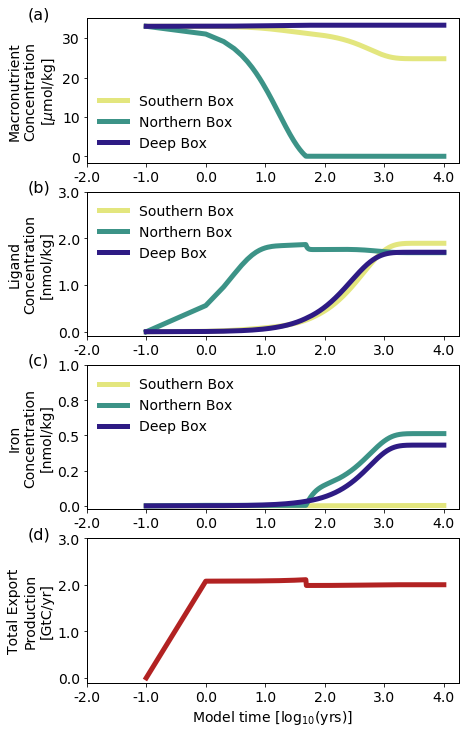

In [9]:
example_gaovla = 5000
example_gamma  = np.array((5e-5*106,))
example_lambda = np.array((1/((example_gamma/106)/example_gaovla)))

pinexample=np.tile(33/R_np,(1,3))
finexample=np.tile(1e-6,(1,3))
linexample=np.tile(1e-6,(1,3))

texample,pexample,fexample,lexample,epexample,nlexample,psexample = nutboxmod.model(1e4,1,
                    pinexample*1.0e-6,finexample*1.0e-9,linexample*1.0e-9,
                    example_gamma,example_lambda,
                    dustdep,alpha_yr,dlambdadz,psi,niters+1)

tlen=np.int(1e4/1)

timeseries_tim=texample[:tlen]*1
timeseries_nso=pexample[0,:tlen]*R_np
timeseries_nna=pexample[1,:tlen]*R_np
timeseries_ndo=pexample[2,:tlen]*R_np
timeseries_fso=fexample[0,:tlen]
timeseries_fna=fexample[1,:tlen]
timeseries_fdo=fexample[2,:tlen]
timeseries_lso=lexample[0,:tlen]
timeseries_lna=lexample[1,:tlen]
timeseries_ldo=lexample[2,:tlen]
timeseries_exp=(epexample[0,:tlen]+epexample[1,:tlen])*117*86400*365*12*1e-15 # convert molP/s to GtC/yr

# Make sure initial conditions are included at t=0
timeseries_tim[0]=timeseries_tim[0]+.1

#Plot the timeseries
fig3, (f3ax1,f3ax2,f3ax3,f3ax4) = plt.subplots(figsize=(1.5*x_fig, 2.75*y_fig),ncols=1,nrows=4)
fig3.patch.set_facecolor('None')
mycm = plt.cm.get_cmap(cm.cm.haline)

# Phosphate
## SO
f3ax1.plot(np.log10(timeseries_tim),timeseries_nso,color=mycm(240),linewidth=5,label="Southern Box")
# AO
f3ax1.plot(np.log10(timeseries_tim),timeseries_nna,color=mycm(128),linewidth=5,label="Northern Box")
# DO
f3ax1.plot(np.log10(timeseries_tim),timeseries_ndo,color=mycm(10),linewidth=5,label="Deep Box")
f3ax1.legend(frameon=False,fontsize=14)
f3ax1.set_ylim(top=np.ceil(np.max(f3ax1.get_ylim())))
f3ax1.set_xlim(left=-2)
f3ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax1.set_ylabel("Macronutrient\nConcentration\n[$\mu$mol/kg]",fontsize=14)
f3ax1.text(-3,np.max(f3ax1.get_ylim()),'(a)',fontsize=16)

# Ligands
# SO
f3ax2.plot(np.log10(timeseries_tim),timeseries_lso,color=mycm(240),linewidth=5,label="Southern Box")
# AO 
f3ax2.plot(np.log10(timeseries_tim),timeseries_lna,color=mycm(128),linewidth=5,label="Northern Box")
# DO
f3ax2.plot(np.log10(timeseries_tim),timeseries_ldo,color=mycm(10),linewidth=5,label="Deep Box")
f3ax2.legend(frameon=False,fontsize=14)
f3ax2.set_ylim(top=3)
f3ax2.set_xlim(left=-2)
f3ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax2.set_ylabel("Ligand\nConcentration\n[nmol/kg]",fontsize=14)
#f3ax2.set_xlabel("Model time [log$_{10}$(yrs)]",fontsize=14)
f3ax2.text(-3,np.max(f3ax2.get_ylim()),'(b)',fontsize=16)

# Iron
# SO
f3ax3.plot(np.log10(timeseries_tim),timeseries_fso,color=mycm(240),linewidth=5,label="Southern Box")
# AO
f3ax3.plot(np.log10(timeseries_tim),timeseries_fna,color=mycm(128),linewidth=5,label="Northern Box")
# DO
f3ax3.plot(np.log10(timeseries_tim),timeseries_fdo,color=mycm(10),linewidth=5,label="Deep Box")
f3ax3.legend(frameon=False,fontsize=14)
f3ax3.set_ylim(top=np.ceil(np.max(f3ax3.get_ylim())))
f3ax3.set_xlim(left=-2)
f3ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax3.set_ylabel("Iron\nConcentration\n[nmol/kg]",fontsize=14)
f3ax3.text(-3,np.max(f3ax3.get_ylim()),'(c)',fontsize=16)

f3ax4.plot(np.log10(timeseries_tim),timeseries_exp,color='firebrick',linewidth=5,label="Southern+Northern")
#f3ax4.legend(frameon=False,fontsize=14)
f3ax4.set_ylim(top=np.ceil(np.max(f3ax4.get_ylim())))
f3ax4.set_xlim(left=-2)
f3ax4.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax4.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f3ax4.set_ylabel("Total Export\nProduction\n[GtC/yr]",fontsize=14)
f3ax4.set_xlabel("Model time [log$_{10}$(yrs)]",fontsize=14)
f3ax4.text(-3,np.max(f3ax4.get_ylim()),'(d)',fontsize=16)

plt.show()     
#fig3.savefig('illustration_of_feedback.pdf',format='pdf',facecolor=fig3.get_facecolor(), edgecolor='none',bbox_inches='tight')

**Figure 4: 10,000 model simulations nutrient and export fluxes**

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log10
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: divide by zero encountered in log10


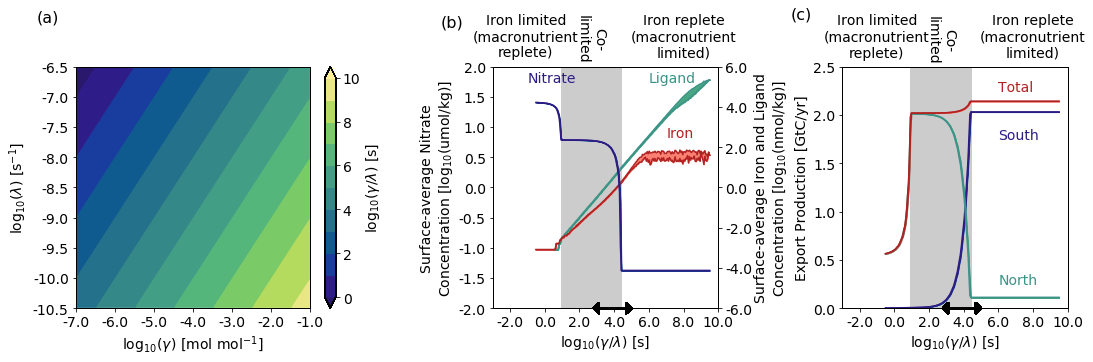

In [10]:
grid_gam   =   np.reshape(gamma,np.shape(grid_gamma))
grid_lt    =1/(np.reshape(inv_lambda ,np.shape(grid_gamma))*3e7)
grid_gaovla=   np.reshape(gamma_over_lambda,np.shape(grid_gamma))

fig4, (f4ax1,f4ax2,f4ax3) = plt.subplots(figsize=(4*x_fig, y_fig),ncols=3,gridspec_kw={'width_ratios': [1.3, 1, 1]})
fig4.patch.set_facecolor('None')
mycm = plt.cm.get_cmap(cm.cm.haline)

f4ax1c1=f4ax1.contourf(np.log10(grid_gam),np.log10(grid_lt),np.log10(grid_gaovla),np.arange(0,11,1),cmap=mycm,vmin=0,vmax=10,extend='both')
# This is the fix for the white lines between contour levels
for a in f4ax1.collections:
    a.set_edgecolor("face")

f4cbar1=fig4.colorbar(f4ax1c1,ax=f4ax1,ticks=np.arange(0,12.0,2.0),extend='both')
f4cbar1.solids.set_edgecolor("face")
f4cbar1.set_label('log$_{10}(\gamma/\lambda)$ [s]',fontsize=14)
f4ax1.set_ylabel('log$_{10}(\lambda)$ [s$^{-1}$]',fontsize=14)
f4ax1.set_xlabel('log$_{10}(\gamma)$ [mol mol$^{-1}$]',fontsize=14)
f4ax1.set_xlim(left=-7,right=-1)
f4ax1.xaxis.set_ticks(np.arange(-7,0,1))
f4ax1.set_ylim(bottom=-10.5,top=-6.5)
f4ax1.yaxis.set_ticks(np.arange(-10.5,-6,0.5))
f4ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax1.text(-8,-5.75,'(a)',fontsize=16)
    
# Macronutrients
f4ax2.plot(np.log10(gaovla_average),np.log10(np.maximum(nsurf_average-nsurf_spread,0.021)),color=mycm(10))
f4ax2.plot(np.log10(gaovla_average),np.log10(nsurf_average+nsurf_spread),color=mycm(10))
f4ax2.fill_between(np.log10(gaovla_average),np.log10(np.maximum(nsurf_average-nsurf_spread,0.021)),np.log10(nsurf_average+nsurf_spread),color=mycm(50))

f4ax2.set_xlabel('log$_{10}(\gamma/\lambda)$ [s]',fontsize=14)
f4ax2.set_xlim(left=-3,right=10)
f4ax2.xaxis.set_ticks(np.arange(-2,12,2))
f4ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax2.set_ylim(bottom=-2,top=2)

# Change plot appearence
if R_np==16:
    f4ax2.set_ylabel('Surface-average Nitrate\nConcentration [log$_{10}$(umol/kg)]',fontsize=14)
    f4ax2.text(np.min(np.log10(gaovla_average)),np.max(f4ax2.get_ylim())-0.25,'Nitrate',color=mycm(10),fontsize=14)
else:
    f4ax2.set_ylabel('Surface-average Phosphate\nConcentration [log$_{10}$(umol/kg)]',fontsize=14)
    f4ax2.text(np.log10(gaovla_average),np.max(f4ax2.get_ylim())-0.3,'Phosphate',color=mycm(10),fontsize=14)


# Second axes for Macronutrients that shares the same x-axis
f4ax2a = f4ax2.twinx()  
# Ligands
f4ax2a.plot(np.log10(gaovla_average),np.log10(lsurf_average-lsurf_spread),color=mycm(128))
f4ax2a.plot(np.log10(gaovla_average),np.log10(lsurf_average+lsurf_spread),color=mycm(128))
f4ax2a.fill_between(np.log10(gaovla_average),np.log10(lsurf_average-lsurf_spread),np.log10(lsurf_average+lsurf_spread),color=mycm(150))
# Iron
f4ax2a.plot(np.log10(gaovla_average),np.log10(fsurf_average-fsurf_spread),'firebrick')
f4ax2a.plot(np.log10(gaovla_average),np.log10(fsurf_average+fsurf_spread),'firebrick')
f4ax2a.fill_between(np.log10(gaovla_average),np.log10(fsurf_average-fsurf_spread),np.log10(fsurf_average+fsurf_spread),color='salmon')

# Change plot appearence
f4ax2a.set_ylim(bottom=-6,top=6)
f4ax2a.set_ylabel('Surface-average Iron and Ligand\nConcentration [log$_{10}$(nmol/kg)]',fontsize=14)
f4ax2a.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Co limitation zone
f4ax2a.fill_between((colimits[0],colimits[1]),
                  np.min(f4ax2a.get_ylim()), np.max(f4ax2a.get_ylim()),color='#cccccc',zorder=-1)

#Change the overlay order
f4ax2.set_zorder(f4ax2.get_zorder()+1)
f4ax2a.patch.set_visible(True)
f4ax2.patch.set_visible(False)

# Labels
f4ax2a.text(-6,np.max(f4ax2a.get_ylim())+2.0,'(b)',fontsize=16)
f4ax2a.text(7,np.max(f4ax2a.get_ylim())-3.5,'Iron',color='firebrick',fontsize=14)
f4ax2a.text(6,np.max(f4ax2a.get_ylim())-.75,'Ligand',color=mycm(128),fontsize=14)
f4ax2a.text(8,np.max(f4ax2a.get_ylim())+.5,'Iron replete\n(macronutrient\nlimited)',horizontalalignment='center',fontsize=14)
f4ax2a.text((colimits[1]+colimits[0])/2,np.max(f4ax2a.get_ylim())+1.25,'Co-\nlimited',rotation=-90,horizontalalignment='center',fontsize=14)
f4ax2a.text(-1.1,np.max(f4ax2a.get_ylim())+.5,'Iron limited\n(macronutrient\nreplete)',horizontalalignment='center',fontsize=14)

# Plot data-based constraint of gamma/lambda
f4ax2a.annotate(s='', xy=(np.max(data_goverl),np.min(f4ax2a.get_ylim())), xytext=(np.min(data_goverl),np.min(f4ax2a.get_ylim())), arrowprops=dict(color='black',arrowstyle='<|-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

# Plot median export values in each basin
f4ax3.plot(np.log10(gaovla_average),exp1_average-exp1_spread,color=mycm(10))
f4ax3.plot(np.log10(gaovla_average),exp1_average+exp1_spread,color=mycm(10),label="Southern")
f4ax3.fill_between(np.log10(gaovla_average),(exp1_average-exp1_spread),(exp1_average+exp1_spread),color=mycm(50))

f4ax3.plot(np.log10(gaovla_average),exp2_average-exp2_spread,color=mycm(128))
f4ax3.plot(np.log10(gaovla_average),exp2_average+exp2_spread,color=mycm(128),label="Northern")
f4ax3.fill_between(np.log10(gaovla_average),(exp2_average-exp2_spread),(exp2_average+exp2_spread),color=mycm(150))

f4ax3.plot(np.log10(gaovla_average),exp_average-exp_spread,'firebrick')
f4ax3.plot(np.log10(gaovla_average),exp_average+exp_spread,'firebrick',label="Northern")
f4ax3.fill_between(np.log10(gaovla_average),(exp_average-exp_spread),(exp_average+exp_spread),color='salmon')

# Change plot appearence
f4ax3.set_ylabel('Export Production [GtC/yr]',fontsize=14)
f4ax3.set_xlabel('log$_{10}$($\gamma/\lambda$) [s]',fontsize=14)
f4ax3.set_xlim(left=-3,right=10)
f4ax3.xaxis.set_ticks(np.arange(-2,12,2))
f4ax3.set_ylim(bottom=0.0,top=2.5)
f4ax3.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f4ax3.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Plot data-based constraint of gamma/lambda
f4ax3.annotate(s='', xy=(np.max(data_goverl),np.min(f4ax3.get_ylim())), xytext=(np.min(data_goverl),np.min(f4ax3.get_ylim())), arrowprops=dict(color='black',arrowstyle='<|-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

f4ax3.text(-6,np.max(f4ax3.get_ylim())+0.5,'(c)',fontsize=16)
f4ax3.text(6,2.25,'Total',color='firebrick',fontsize=14)
f4ax3.text(6,1.75,'South',color=mycm(10),fontsize=14)
f4ax3.text(6,0.25,'North',color=mycm(128),fontsize=14)
f4ax3.text(8,1.04*np.max(f4ax3.get_ylim()),'Iron replete\n(macronutrient\nlimited)',horizontalalignment='center',fontsize=14)
f4ax3.text((colimits[1]+colimits[0])/2,1.1*np.max(f4ax3.get_ylim()),'Co-\nlimited',rotation=-90,horizontalalignment='center',fontsize=14)
f4ax3.text(-1,1.04*np.max(f4ax3.get_ylim()),'Iron limited\n(macronutrient\nreplete)',horizontalalignment='center',fontsize=14)

# Co limitation zone
f4ax3.fill_between((colimits[0],colimits[1]),
                  np.min(f4ax3.get_ylim()), np.max(f4ax3.get_ylim()),color='#cccccc',zorder=-1)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.5)
plt.show()     
#fig4.savefig('ensemble_nutrients_export_plot.pdf',format='pdf',facecolor=fig4.get_facecolor(), edgecolor='none',bbox_inches='tight')
   

**Figure 5: 10,000 model simulations model-data comparison using objective function**

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less_equal
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in less_equal
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in less_equal


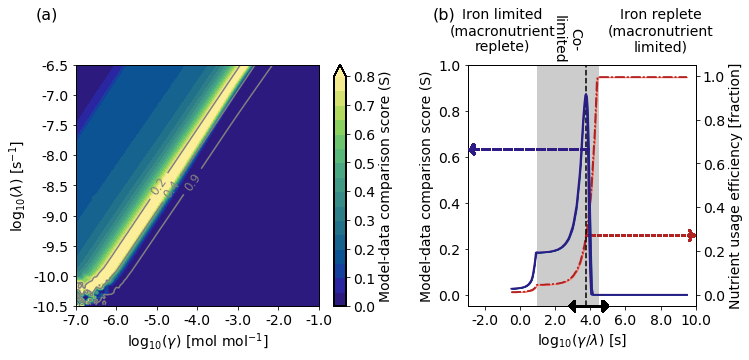

In [11]:
jgrid =np.reshape(jovern,np.shape(grid_gamma))
pgrid =np.reshape(pstar ,np.shape(grid_gamma))

fig5, (f5ax1,f5ax2) = plt.subplots(figsize=(2.5*x_fig, y_fig),ncols=2,gridspec_kw={'width_ratios': [1.2,0.9]})
fig5.patch.set_facecolor('None')


f5ax1c1=f5ax1.contourf(np.log10(grid_gam),np.log10(grid_lt),jgrid,np.arange(0,0.85,0.05),cmap=mycm,vmin=0,vmax=0.8,extend='max')
for a in f5ax1.collections:
    a.set_edgecolor("face")
f5cbar1=fig5.colorbar(f5ax1c1,ax=f5ax1,ticks=np.arange(0,0.9,0.1),extend='max')
f5cbar1.solids.set_edgecolor("face")
f5cbar1.set_label('Model-data comparison score (S)',fontsize=14)

# Contour macronutrient use efficiency
f5ax1c2=f5ax1.contour(np.log10(grid_gam),np.log10(grid_lt),pgrid,levels=(0.2,0.4,0.9),colors='gray')
f5ax1.clabel(f5ax1c2,(0.2,0.4,0.9), inline=True, fmt='%.1f', fontsize=12,manual=[(-5.5, -8.25), (-4.75,-8.5), (-4,-8.5)],colors='gray')

f5ax1.set_ylabel('log$_{10}(\lambda)$ [s$^{-1}$]',fontsize=14)
f5ax1.set_xlabel('log$_{10}(\gamma)$ [mol mol$^{-1}$]',fontsize=14)
f5ax1.set_xlim(left=-7,right=-1)
f5ax1.xaxis.set_ticks(np.arange(-7,0,1))
f5ax1.set_ylim(bottom=-10.5,top=-6.5)
f5ax1.yaxis.set_ticks(np.arange(-10.5,-6,0.5))
f5ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f5ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f5ax1.text(-8,-5.75,'(a)',fontsize=16)

# Plot vertical lines for lambda/gamma value that minimizes the cost function
f5ax2.axvline(np.log10(gaovla_average[np.nanargmax(jovern_average)]),linestyle='--',color='black')

# Plot Objective function values
f5ax2.plot(np.log10(gaovla_average),jovern_average-jovern_spread,color=mycm(10))
f5ax2.plot(np.log10(gaovla_average),jovern_average+jovern_spread,color=mycm(10))
f5ax2.fill_between(np.log10(gaovla_average), jovern_average-jovern_spread,jovern_average+jovern_spread,color=mycm(50))
     
# Change plot appearence
f5ax2.set_ylabel('Model-data comparison score (S)',fontsize=14)
f5ax2.set_xlabel('log$_{10}$($\gamma/\lambda$) [s]',fontsize=14)
f5ax2.set_xlim(left=-3,right=10)
f5ax2.xaxis.set_ticks(np.arange(-2,12,2))
f5ax2.set_ylim(bottom=-0.05,top=1)
f5ax2.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# Plot horizontal line where cost function uses the value for 1nm fixed ligand concentration
f5ax2.annotate(s='', xy=(np.min(f5ax2.get_xlim()),jovern_fixed1nmlig,), xytext=(np.log10(np.min(gaovla_average[np.logical_and(gaovla_average>gaovla_average[np.nanargmax(jovern_average)],jovern_average<=jovern_fixed1nmlig)])),jovern_fixed1nmlig), arrowprops=dict(color=mycm(10),linestyle='--',arrowstyle='-|>,head_width=0.5,head_length=0.5',shrinkA=0, shrinkB=0, linewidth=2))

# Plot data-based constraint of gamma/lambda
f5ax2.annotate(s='', xy=(np.max(data_goverl),np.min(f5ax2.get_ylim())), xytext=(np.min(data_goverl),np.min(f5ax2.get_ylim())), arrowprops=dict(color='black',arrowstyle='<|-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

f5ax2.text(-5,1.2,'(b)',fontsize=16)
f5ax2.text(8,1.06,'Iron replete\n(macronutrient\nlimited)',horizontalalignment='center',fontsize=14)
f5ax2.text((colimits[1]+colimits[0])/2,1.1,'Co-\nlimited',rotation=-90,horizontalalignment='center',fontsize=14)
f5ax2.text(-1,1.06,'Iron limited\n(macronutrient\nreplete)',horizontalalignment='center',fontsize=14)

# Second axes for P* that shares the same x-axis
f5ax2a = f5ax2.twinx()
plt.plot(np.log10(gaovla_average),(pstar_average-pstar_spread),color='firebrick',linestyle='-.')
plt.plot(np.log10(gaovla_average),(pstar_average+pstar_spread),color='firebrick',linestyle='-.')
plt.fill_between(np.log10(gaovla_average),(pstar_average-pstar_spread),(pstar_average+pstar_spread),color='salmon')
f5ax2a.set_ylabel('Nutrient usage efficiency [fraction]',fontsize=14)  
f5ax2a.set_ylim(bottom=-0.05,top=1.05)

# Optimum model macronutrient usage efficiency
f5ax2a.annotate(s='', xy=(np.max(f5ax2a.get_xlim()),pstar_average[np.nanargmax(jovern_average)],), xytext=(np.log10(gaovla_average[np.nanargmax(jovern_average)]),pstar_average[np.nanargmax(jovern_average)]), arrowprops=dict(color='firebrick',linestyle=':',arrowstyle='-|>,head_width=0.5,head_length=0.5', shrinkA=0, shrinkB=0, linewidth=2))

# The range for macronutrient usage efficiency values bounded by jovern>=jovern_fixed1nmlig is 
pstar_range=np.array((\
                np.max(pstar_average[np.logical_and(gaovla_average<gaovla_average[np.nanargmax(jovern_average)],jovern_average<=jovern_fixed1nmlig)]),
                np.min(pstar_average[np.logical_and(gaovla_average>gaovla_average[np.nanargmax(jovern_average)],jovern_average<=jovern_fixed1nmlig)])
                ))

# Co limitation zone
f5ax2a.fill_between((colimits[0],colimits[1]),
                  np.min(f5ax2a.get_ylim()), np.max(f5ax2a.get_ylim()),color='#cccccc',zorder=-1)

# move ax in front
f5ax2.set_zorder(f5ax2a.get_zorder() + 1)
f5ax2.patch.set_visible(False)

# Can adjust the subplot size
plt.subplots_adjust(wspace=0.33)
plt.show()
#fig5.savefig('ensemble_model_data_plot.pdf',format='pdf',facecolor=fig5.get_facecolor(), edgecolor='none',bbox_inches='tight')